# Half-space Monte Carlo AVO modelling

This functionality replaces the Blocky Ops AVO modelling in RokDoc, and has the advantage that you can easily use a half-space model that takes input from multiple wells.

Make sure that you have covered *introduction to blixt_rp.ipynb* before starting here, and preferably also *run fluid substitution.ipynb* and *run calculation of Sums and Averages.ipynb*

Import the necessary python scripts

In [2]:
import os
import sys

# working_dir = 'C:\\Users\\marten\\PycharmProjects\\blixt_rp'
working_dir = 'C:\\Users\\MårtenBlixt\\PycharmProjects\\blixt_rp'
sys.path.append(working_dir)

#the following two lines are only necessary when working with local development versions of the code
sys.path.append('C:\\Users\\MårtenBlixt\\PycharmProjects\\blixt_rp')
sys.path.append('C:\\Users\\MårtenBlixt\\PycharmProjects\\blixt_utils')

import blixt_rp.rp_utils.half_space_avo_monte_carlo as havo
import blixt_utils.io.io as uio
from blixt_rp.rp_utils.calc_stat_class import SetUpCalculation, CalculateStats

We run a fluid substitution on *Well F*, which is the only well we have a water saturation log for, then we calculate the statistics over this well, and use those results when building the half-space model.

It must be noted that the statistics can be calculated across many wells, but in this example we can only run the fluid substition on Well F.

First we need to make sure that *Well F* is active in the project table *project_table.xlsx*, and then open the existing project

In [4]:
import MyProject as mp
wp, wells, templates, wis = mp.init(working_dir, new=False)
w = wells['WELL_F']
print(w.log_names())

['vp_so08', 'vp_dry', 'vs_sg08', 'rho_dry', 'vp_sg08', 'sw', 'vcl', 'depth', 'tvd', 'rho_so08', 'inc', 'rho_sg08', 'vs_dry', 'twt_from_interp', 'phie', 'vs_so08']


Then we run the predefined fluid substitution in Well F using the script:

In [5]:
mp.predefined_fluid_subs(wp, wells, templates, wis)

INFO: Extract water depth in well WELL_F from templates
INFO: Extract water depth in well WELL_F from templates
INFO: Extract water depth in well WELL_F from templates
INFO: Extract water depth in well WELL_F from templates
INFO: Extract kb in well WELL_F from templates
INFO: Extract water depth in well WELL_F from templates
INFO: Extract kb in well WELL_F from templates
Well WELL_A not listed in the fluid mixture, skipping
Well WELL_B not listed in the fluid mixture, skipping
Well WELL_C not listed in the fluid mixture, skipping
INFO: Starting Gassmann fluid substitution on well WELL_F
INFO: Calculating Voigt-Reuss-Hill bound of k for well WELL_F in interval SAND E
  quartz    K: 36.6, Mu: 45.0, Rho 2.65
    Volume fraction: complement
  shale    K: 22.337340368891446, Mu: 11.096107785059152, Rho 2.5890000000000004
    Volume fraction: vcl

 Mineral k: quartz, volume frac: complement
 Mineral k: shale, volume frac: vcl
INFO: Calculating Voigt bound of rho for well WELL_F in interval S

C:\Users\MårtenBlixt\PycharmProjects\blixt_rp\blixt_rp\rp\rp_core.py:1043: RuntimeWarning: invalid value encountered in sqrt
  v_p_2 = np.sqrt((k_2+(4/3)*mu_2) / rho_2) * 1E3  # m/s


*Well F* now have some new well logs resulting from the well log:

In [4]:
print(w.log_names())

['vp_sg08', 'twt_from_interp', 'tvd', 'rho_sg08', 'inc', 'vp_dry', 'vs_sg08', 'vs_dry', 'vp_so08', 'vs_dry_fs', 'rho_so08', 'rho_dry_fs', 'vcl', 'phie', 'rho_dry', 'vs_so08', 'sw', 'vp_dry_fs', 'depth']


The log names with postfix *_fs* are new, and results from the fluid substitution in the working interval *Sand E*, 

<img src="images/Fluid substitution - fluidmixs.png" />

Calculate the statistics in this working interval, and for the shale in interval *Shale C*, for *Well F*, and store the result in a new excel file: 

Interval: Sand E
 sand_dry. Volume<0.50, Porosity>0.10
Creating new RokDoc Sums and Averages file
Appending to existing RokDoc Sums and averages file
Interval: Sand E
 sand_fs. Volume<0.50, Porosity>0.10
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file
Interval: Shale C
 shale. Volume>0.50, Porosity<0.10
Appending to existing RokDoc Sums and averages file
Appending to existing RokDoc Sums and averages file


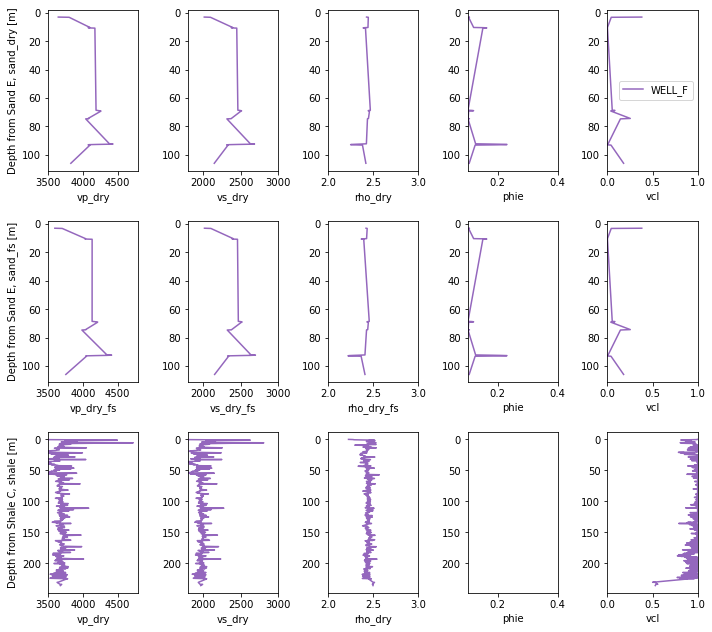

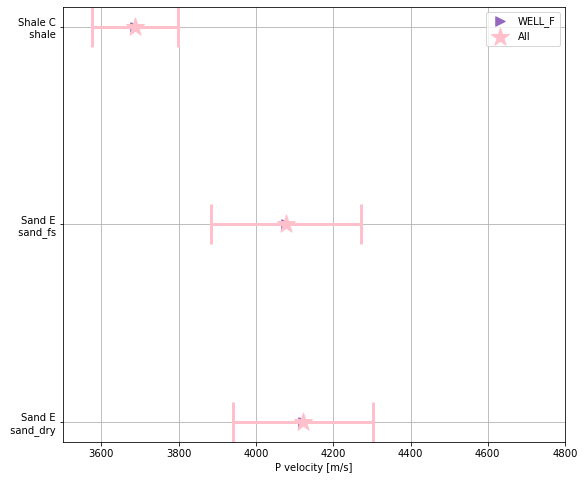

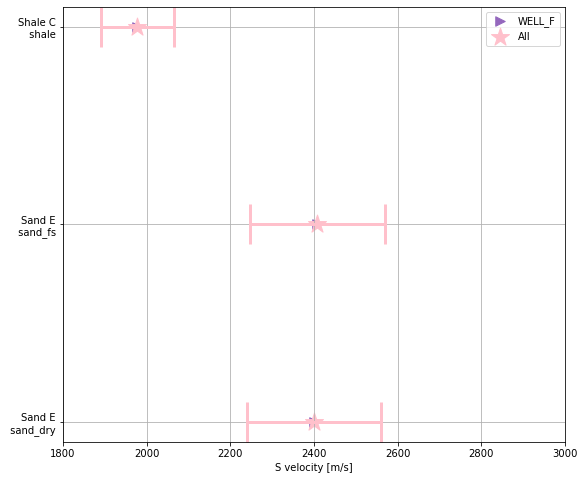

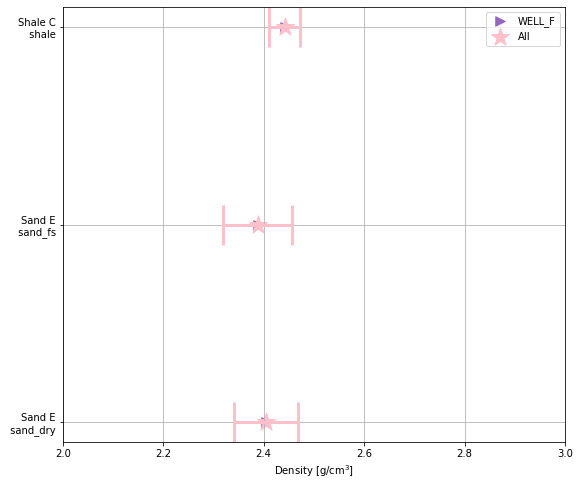

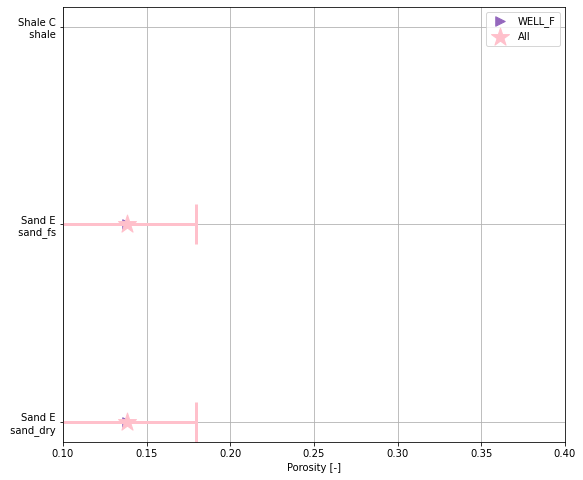

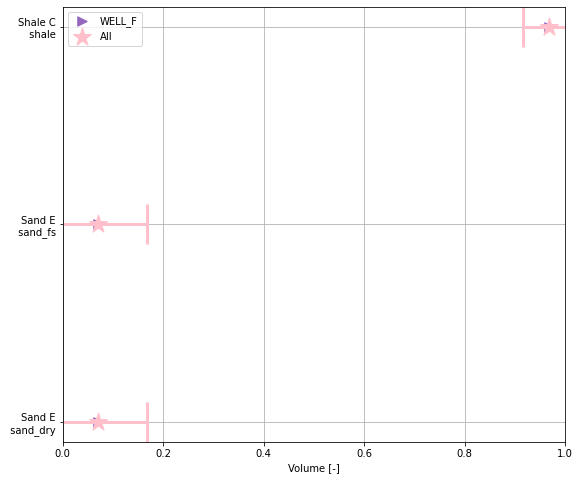

In [6]:
rokdoc_output=os.path.join(wp.working_dir, 'results_folder', 'SumsAndAverages_fs.xlsx')

cutoffs_sands = {'Volume': ['<', 0.5], 'Porosity': ['>', 0.1]}
cutoffs_shales = {'Volume': ['>', 0.5], 'Porosity': ['<', 0.1]}

log_table = {'P velocity': 'vp_dry', 'S velocity': 'vs_dry', 'Density': 'rho_dry', 'Porosity': 'phie', 'Volume': 'vcl'}
log_table_fs = {'P velocity': 'vp_dry_fs', 'S velocity': 'vs_dry_fs', 'Density': 'rho_dry_fs', 'Porosity': 'phie', 'Volume': 'vcl'}

stats_set_up = SetUpCalculation(
    {'WELL_F': wells['WELL_F']},
    ['Sand E', 'Sand E', 'Shale C'],
    [cutoffs_sands, cutoffs_sands, cutoffs_shales],
    [log_table, log_table_fs, log_table],
    ['sand_dry', 'sand_fs', 'shale'],
    wis,
    templates,
    rokdoc_output=rokdoc_output,
    working_dir=os.path.join(wp.working_dir, 'results_folder')
)
stat_results = CalculateStats(stats_set_up)

Use the output (*rokdoc_output*) excel file, and build a half-space model based on that by defining the intervals that make up the top(s) and base(s) of the half-space model(s)
It is a complicated list of list of lists, with the inner most list contains 
 - ['top_name', 'base_name', 'color']
 
which define one half-space model, and the color of how it is plottet.
The names must exist in the above given excel file.
For name of python plot colors see https://matplotlib.org/2.0.2/api/colors_api.html

The next layer of lists is used if you want to combine several half-space models in the same plot
And the outermost layer of list can be used to run several monte-carlo simulations at once. 
The list of suffixes are used in the naming of the plots


In [8]:
many_interfaces = [
        [['Shale C_shale', 'Sand E_sand_dry', 'b'],  # Brine case
         ['Shale C_shale', 'Sand E_sand_fs', 'g']]  # Oil case        
    ]
suffixes = [
        'test',
]

Read in the Sums & Averages file

In [11]:
sums = uio.read_sums_and_averages(rokdoc_output)

In [17]:
print(sums['Sand E_sand_dry']['VpMedian'])

4101.61975


And then run the Monte Carlo half-space modelling:

Class I: 61% 
Class IIp: 32% 
Class II: 4% 
Class III: 0% 
Class IV: 1%
Rest:  0%
Class I: 28% 
Class IIp: 61% 
Class II: 8% 
Class III: 3% 
Class IV: 1%
Rest:  0%


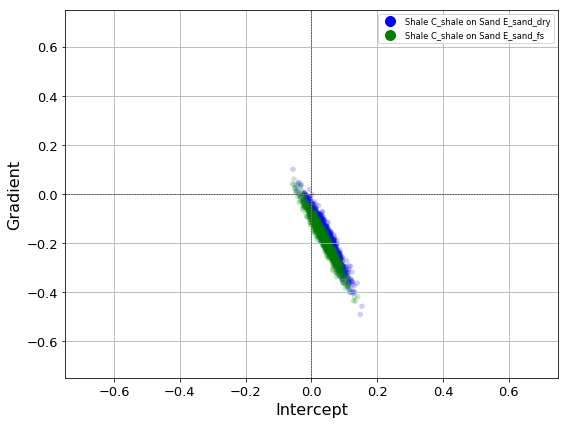

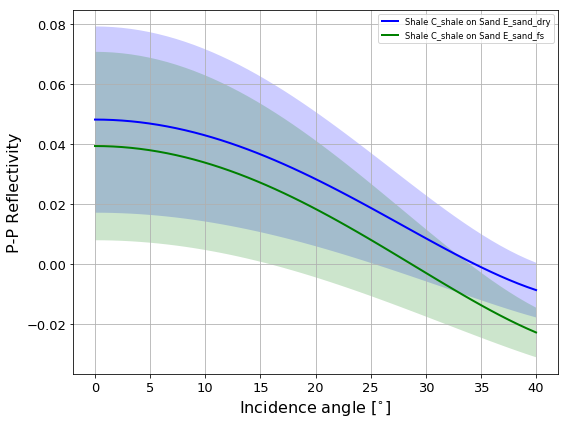

In [14]:
for i, interfaces in enumerate(many_interfaces):
    havo.plot_multi_interfaces(
            sums, 
            interfaces, 
            fbase=os.path.split(rokdoc_output)[0],
            suffix=suffixes[i])
        


The resulting plots show that there is a small separation in *Intercept vs. Gradient* space between the brine and oil cale.

In the brine case, 61% of the modelled responses are classified as AVO class I, while in the oil case 61% of the model results are classified as AVO class IIP, and the gradients are very similar for both brine and oil.